In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
df_train = pd.read_csv('train.csv')

In [84]:
class ConvolutionLayer:
    
    def __init__(self,kernel_num,kernel_size):
        
        self.kernel_num=kernel_num
        self.kernel_size=kernel_size
        self.kernels=np.random.randn(kernel_num,kernel_size,kernel_size)/(kernel_size**2)
        
    def patches_generator(self,image):
        
        image_h, image_w = image.shape
        self.image=image
        
        for h in range(image_h-self.kernel_size+1):
            for w in range(image_w-self.kernel_size+1):
                patch=image[h:(h+self.kernel_size),w:(w+self.kernel_size)]

                yield patch,h,w
                
    def forward_prop(self,image):
        
        image_h, image_w = image.shape
        
        convolution_output=np.zeros((image_h-self.kernel_size+1,image_w-self.kernel_size+1,self.kernel_num))
        
        for patch,h,w in self.patches_generator(image):
            
            convolution_output[h,w]=np.sum(patch*self.kernels,axis=(1,2))
            
        return convolution_output
    
    def back_prop(self,dE_dY,alpha):
        
        dE_dk=np.zeros(self.kernels.shape)
        
        for patch,h,w in self.patches_generator(self.image):
            for f in range(self.kernel_num):
                
                dE_dk[f]+=patch*dE_dY[h,w,f]
                
        self.kernels-=alpha*dE_dk
        
        return dE_dk

In [85]:
class MaxPoolingLayer:
    
    def __init__(self,kernel_size):
        
        self.kernel_size=kernel_size
        
        
    def patches_generator(self,image):
        
        output_h=image.shape[0]//self.kernel_size
        output_w=image.shape[1]//self.kernel_size
        self.image=image
        
        for h in range(output_h):
            for w in range(output_w):
                
                patch=image[(h*self.kernel_size):(h*self.kernel_size+self.kernel_size),(w*self.kernel_size):(w*self.kernel_size+self.kernel_size)]
                
                yield patch, h ,w
                
    def forward_prop(self,image):
        
        image_h,image_w, num_kernels= image.shape
        max_pooling_output= np.zeros((image_h//self.kernel_size,image_w//self.kernel_size,num_kernels))
        
        for patch,h,w in self.patches_generator(image):  
            max_pooling_output[h,w]=np.amax(patch,axis=(0,1))
            
        return max_pooling_output
            
    def back_prop(self,dE_dY):
        
        dE_dk=np.zeros(self.image.shape)
        
        for patch,h,w in self.patches_generator(self.image):
            
            image_h,image_w,num_kernels=patch.shape
            max_val=np.amax(patch,axis=(0,1))
            
            for idx_h in range(image_h):
                for idx_w in range(image_w):
                    for idx_k in range(num_kernels):
                        
                        if patch[idx_h,idx_w,idx_k]==max_val[idx_k]:
                            dE_dk[h*self.kernel_size+idx_h,w*self.kernel_size+idx_w,idx_k]=dE_dY[h,w,idx_k]
                            
            return dE_dk
        

In [86]:
 class SoftmaxLayer:
        
        def __init__(self,input_units,output_units):
            
            self.weight=np.random.randn(input_units,output_units)/input_units
            self.bias=np.zeros(output_units)
            
        def forward_prop(self,image):
            
            self.original_shape=image.shape  
            image_flattened=image.flatten()
            self.flattened_input=image_flattened
            
            first_output=np.dot(image_flattened,self.weight)+self.bias
            self.output=first_output
            
            softmax_output=np.exp(first_output)/np.sum(np.exp(first_output),axis=0)
            
            return softmax_output
        
        def back_prop(self,dE_dY,alpha):
            
            for i,gradient in enumerate(dE_dY):
                if gradient==0:
                    continue
                    
                transformation_eq=np.exp(self.output)
                S_total=np.sum(transformation_eq)
                
                dY_dZ= - transformation_eq[i]*transformation_eq/(S_total**2)
                dY_dZ[i]=transformation_eq[i]*(S_total-transformation_eq[i])/(S_total**2)
                
                dZ_dw=self.flattened_input
                dZ_db=1
                dZ_dX=self.weight
                
                dE_dZ=gradient*dY_dZ
                
                dE_dw=dZ_dw[np.newaxis].T @ dE_dZ[np.newaxis]
                
                dE_db=dE_dZ*dZ_db
                dE_dX=dZ_dX @ dE_dZ
                
                self.weight-=alpha*dE_dw
                self.bias-= alpha*dE_db
                
                return dE_dX.reshape(self.original_shape)
             

In [87]:
def CNN_forward(image,label,layers):
    
    output=image/255
    for layer in layers:
        output=layer.forward_prop(output)
        
    loss = -np.log(output[label])
    accuracy= 1 if np.argmax(output)==label else 0
    
    return output, loss , accuracy

def CNN_backprop(gradient,layers,alpha=0.05):
    
    grad_back=gradient
    
    for layer in layers[::-1]:
        if type(layer) in [ConvolutionLayer, SoftmaxLayer]:
            grad_back = layer.back_prop(grad_back, alpha)
        elif type(layer) == MaxPoolingLayer:
            grad_back = layer.back_prop(grad_back)
    return grad_back

def CNN_training(image,label,layers,alpha=0.05):

    output,loss,accuracy = CNN_forward(image,label,layers)
    gradient=np.zeros(10)
    gradient[label]= -1/output[label]
    
    gradient_back=CNN_backprop(gradient,layers,alpha)
    
    return loss , accuracy

In [88]:
img = df_train.iloc[40,:].values[1:]
img = np.reshape(img,(28,28))

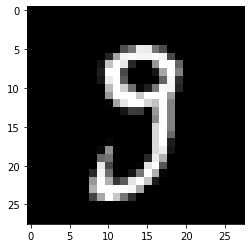

In [89]:
plt.imshow(img, cmap='gray')
plt.show()

In [90]:
my_conv = ConvolutionLayer(32,3)

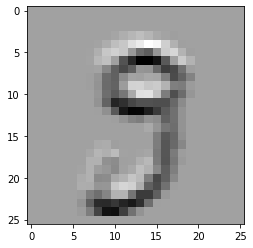

In [91]:
output = my_conv.forward_prop(img)
plt.imshow(output[:,:,15], cmap='gray')

In [92]:
def main():
    (X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
    X_train = X_train[:5000]
    y_train = y_train[:5000]

    layers = [
    ConvolutionLayer(16,3), # layer with 8 3x3 filters, output (26,26,16)
    MaxPoolingLayer(2), # pooling layer 2x2, output (13,13,16)
    SoftmaxLayer(13*13*16, 10) # softmax layer with 13*13*16 input and 10 output
    ] 

    for epoch in range(4):
        print('Epoch {} ->'.format(epoch+1))
        # Shuffle training data
        permutation = np.random.permutation(len(X_train))
        X_train = X_train[permutation]
        y_train = y_train[permutation]
        # Training the CNN
        loss = 0
        accuracy = 0
        for i, (image, label) in enumerate(zip(X_train, y_train)):
            if i % 100 == 0: # Every 100 examples
                print("Step {}. For the last 100 steps: average loss {}, accuracy {}".format(i+1, loss/100, accuracy))
                loss = 0
                accuracy = 0
            loss_1, accuracy_1 = CNN_training(image, label, layers)
            loss += loss_1
            accuracy += accuracy_1

In [ ]:
main()

Epoch 1 ->
Step 1. For the last 100 steps: average loss 0.0, accuracy 0
Step 101. For the last 100 steps: average loss 1.6973917421220577, accuracy 52
Step 201. For the last 100 steps: average loss 1.0024078522556268, accuracy 79
Step 301. For the last 100 steps: average loss 0.8880129057378323, accuracy 76
Step 401. For the last 100 steps: average loss 0.7113435716250008, accuracy 82
Step 501. For the last 100 steps: average loss 0.6219308902811744, accuracy 87
Step 601. For the last 100 steps: average loss 0.7736971079373202, accuracy 79
Step 701. For the last 100 steps: average loss 0.533159403462154, accuracy 86
Step 801. For the last 100 steps: average loss 0.6946949000687703, accuracy 78
Step 901. For the last 100 steps: average loss 0.3902279956804972, accuracy 90
Step 1001. For the last 100 steps: average loss 0.6255891259184116, accuracy 82
Step 1101. For the last 100 steps: average loss 0.43879498263719896, accuracy 86
Step 1201. For the last 100 steps: average loss 0.5218216